In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect
from scipy.optimize import root_scalar
from scipy.stats import linregress
import seaborn as sns
from collections import deque

In [2]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution for the option price of an european put option
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Option price"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0,sigma, r, T, m,N):
    """This function returns N GBM, each evaluated at time T/m,...,T with a starting value of S_0

    Parameters
    ----------
    S_0 : float
        Initial value of the geometric Brownian motion
    sigma : float
        Volatility of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    T : float
        Time horizon of the geometric Brownian motion 
    m : int
        Number of time steps
    N : int
        Number of GBM to generate

    Returns
    -------
    S : np.ndarray
        N GBM evaluated at time T/m,...,T (N_features, m_features)
    """
    simulations = np.ndarray((N, m))
    expXt = st.lognorm.rvs(s=np.sqrt(sigma ** 2 * T / m), loc=0, scale=np.exp((r - 0.5 * sigma ** 2) * T / m), size=m*N)
    expXt_reshaped = expXt.reshape((N, m), order='F')  # Reshape the array to m rows and N columns
    simulations = np.cumprod(np.concatenate([np.ones((N, 1)) * S_0, expXt_reshaped], axis=1), axis=1)
    return simulations[:, 1:]

def RM_European(n, N, rho, K, S0, T, r, I_market,sigma_0 = 1):
    """This function returns the estimated volatility for the option price to equal to market price using the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    sigma_0 : float
        Initial guess of the volatility

    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0) # Fixed constant in the algorithm

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Compute Jhat
        stock_prices = Simulate_Stock_Price(S0, sigma_cur, r, T, m=1, N=N)
        payoffs = np.exp(-r*T) * np.maximum(K - stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Question 1: Retrieve the true volatility 

In [3]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)
print()
print(f" The sigma optimal for Imarket = {I_m} is sigma_opt = {sigma_opt}")
print()
print(f" This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = {I(sigma_opt)}")

0.508372926009589

 The sigma optimal for Imarket = 22 is sigma_opt = 0.508372926009589

 This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = 21.999999999986855


Question 2: RM algorithm to obtain the volatility

Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

rho = 0.8, N = 1, Convergence Rate: 0.7578368052233487
rho = 0.8, N = 10, Convergence Rate: 0.7814010153369182
rho = 0.8, N = 100, Convergence Rate: 0.779544114959823
rho = 1, N = 1, Convergence Rate: 0.29363300665696157
rho = 1, N = 10, Convergence Rate: 0.28948729458018396


findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.


rho = 1, N = 100, Convergence Rate: 0.2902006086225158


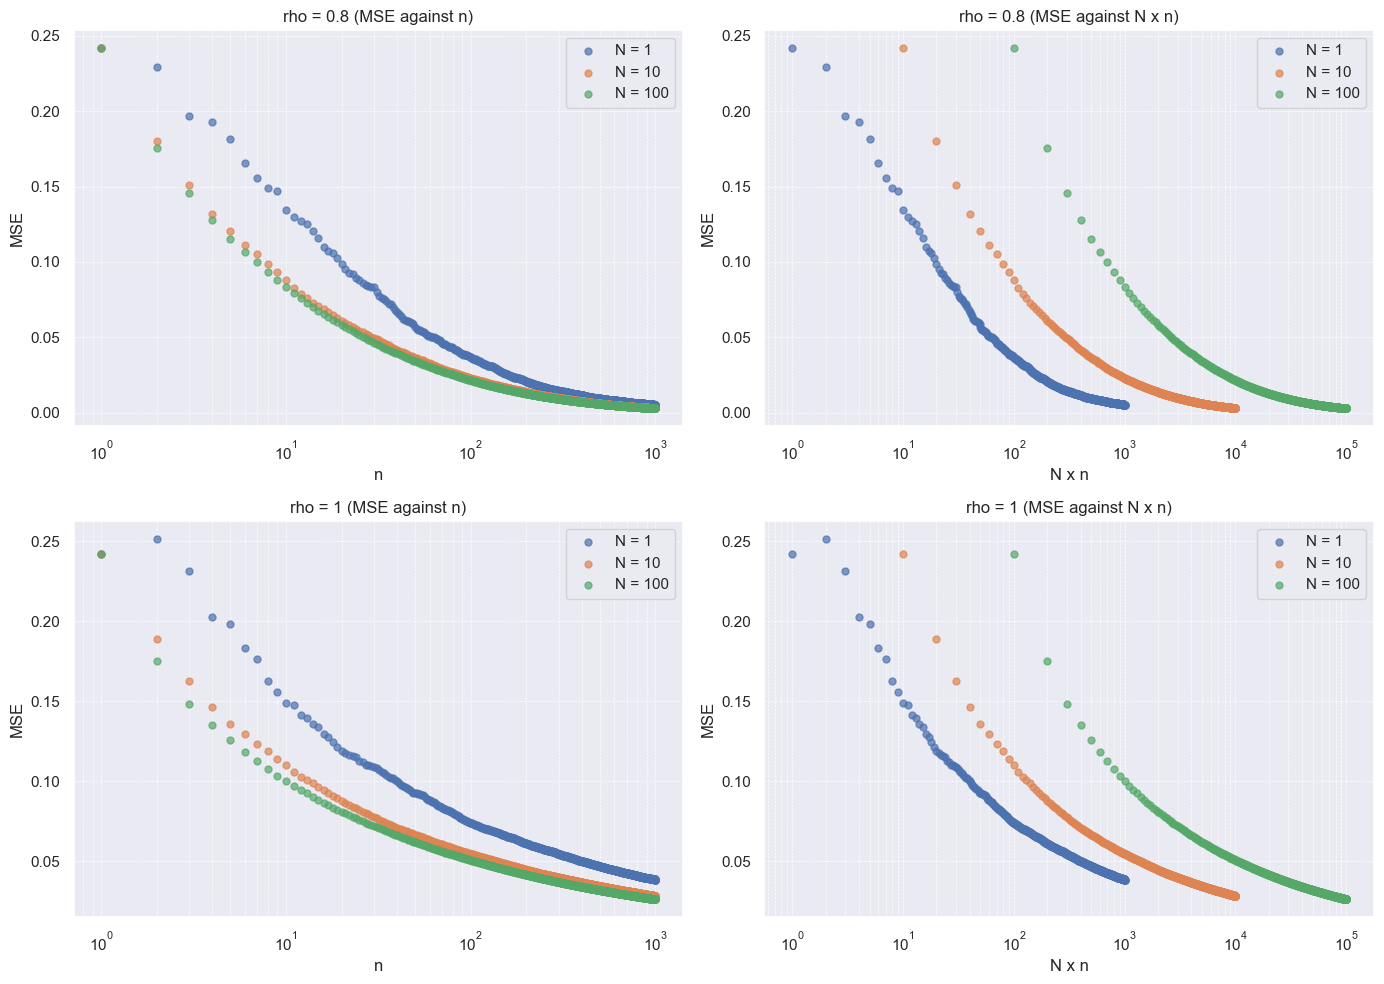

In [4]:
n = 1000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
# Setting seaborn style
sns.set(style="darkgrid")

# Create a 2x2 subplot using seaborn style
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, rho in enumerate([0.8, 1]):
    axes[i, 0].set_title(f'rho = {rho} (MSE against n)')
    axes[i, 1].set_title(f'rho = {rho} (MSE against N x n)')

    for N in [1, 10, 100]:
        all_sigma_estim = np.empty((iterations, n))
        for j in range(iterations):
            all_sigma_estim[j] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        axes[i, 0].scatter(np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)
        axes[i, 1].scatter(N * np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)

        # Calculate convergence rate
        log_n_iterations = np.log(np.arange(1, n+1))
        log_errors = np.log(MSE)
        convergence_rate = -linregress(log_n_iterations, log_errors)[0]
        print(f'rho = {rho}, N = {N}, Convergence Rate: {convergence_rate}')

    # Setting labels, legends, and log scale for x-axis
    for ax in axes[i, :]:
        ax.set_xscale('log')
        ax.legend()
        ax.set_xlabel('n' if ax == axes[i, 0] else 'N x n')
        ax.set_ylabel('MSE')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Part 2: Asian Option 

In [5]:
def RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """This function returns the estimated volatility for the option price to equal to market price using the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    m : int
        Number of time steps GBM
    sigma_0 : float
        Initial guess of the volatility
    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_cur = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_cur = sigma_cur - alpha_n * Jhat
        sigma_estim[i] = sigma_cur

    return sigma_estim


def RM_Asian_mean(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """This function returns the estimated volatility for the option price to equal to market price using a variant of the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    m : int
        Number of time steps GBM
    sigma_0 : float
        Initial guess of the volatility
    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    mean_it : np.ndarray
        Estimated valued of J at each iteration  (n_features, )
    """

    alpha_0 = 2/(K+S0)
    tol = 1 

    sigma_estim = np.empty((n,))
    mean_it = np.empty((n,))

    sigma_estim[0] = sigma_0
    
    simulations = Simulate_Stock_Price(S0, sigma_0 , r, T, m, N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    mean_it[0] = np.mean(Z)


    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat
        mean_it[i] = Jhat


    return sigma_estim,mean_it

In [96]:
# Implement with a MC approximation. Otherwise do same time it gets negative with rho = 0.75
# Or we retrieve the sigma where J is the closest to 0 -> variance MC supremacy 
def RM_Asian_optimized(K, S0, T, r, I_market, m,sigma_0,M=4000):
    """This function returns the estimated volatility for the option price to equal to market price using a variant of the Robbins-Monro algorithm
    Parameters
    ----------
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    m : int
        Number of time steps GBM
    sigma_0 : float
        Initial guess of the volatility
    M : int
        Number of iterations for the normal algorithm
    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0)
    rho_0 = 0.5
    N = 4000

    sigma_estim = []
    sigma_estim = np.append(sigma_estim,sigma_0)

    # First iteration is done outside the loop
    simulations = Simulate_Stock_Price(S0, sigma_0, r, T, m, N)
    avg_stock_prices = np.mean(simulations, axis=1)
    payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
    # Initialization
    Jhat_prev = np.mean(payoffs) - I_market
    Jhat_curr = np.mean(payoffs) - I_market

    i = 0

    #Agressive Algorithm
    while ( Jhat_prev * Jhat_curr >0):
        i += 1
        alpha_n = alpha_0 / i ** rho_0
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        sigma_estim = np.append(sigma_estim, sigma_cur - alpha_n * Jhat)

        Jhat_prev = Jhat_curr
        Jhat_curr = Jhat
    
    print(Jhat_curr)
    print(sigma_estim[-1])
    #Normal Algorithm (sigma is already close to the optimal value) 
    rho = 0.5

    for j in range(i, i+M):
        print(j)
        alpha_n = alpha_0 / (j ** rho)
        sigma_cur = sigma_estim[j - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        sigma_estim = np.append(sigma_estim,sigma_cur - alpha_n * Jhat)
    
    return np.mean(sigma_estim[i:i+M])

K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
print(RM_Asian_optimized(K, S0, T, r, I_market, m = 50, sigma_0 = 5 ,M=10000))

-0.33401863790293973
0.8957086774513077
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799


Question 5: Find optimal volatility 

Understand the effect of each parameter in the algorithm

Rho is an agressiveness parameter. The algorithm stabilizes faster for rho=0.5 since the step size remains relatively large, but a lot of the variance in the estimation of Jhat(sigma) carries over to the algorithm's prediction of sigma_*

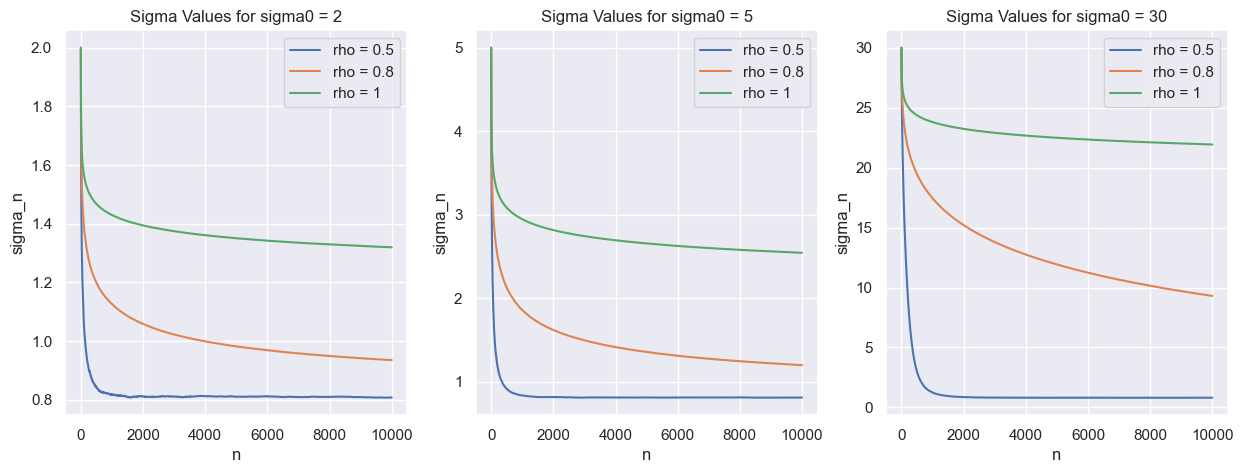

In [142]:
n = 10000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma_0_values = [2,5,30]
rho_values = [0.5,0.8,1]

fig, axes = plt.subplots(1,len(sigma_0_values), figsize=(15, 5))

for i, sigma_0 in enumerate(sigma_0_values):
    for j,rho in enumerate(rho_values):
        sigmas= RM_Asian(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma_0)
        axes[i].plot(sigmas, label=f'rho = {rho}')
        axes[i].set_title(f'Sigma Values for sigma0 = {sigma_0}')
    axes[i].legend()
    axes[i].set_xlabel('n')
    axes[i].set_ylabel('sigma_n')

N: number of sample for MC estimate of J

Result:
- no added benifit for N>2000, we still have a good amount of variance. Its not that detrimental to the algorithm. we can take N = 10000, but then it will be too slow
- The result with CLt Berry Essen sucks due to lognormality

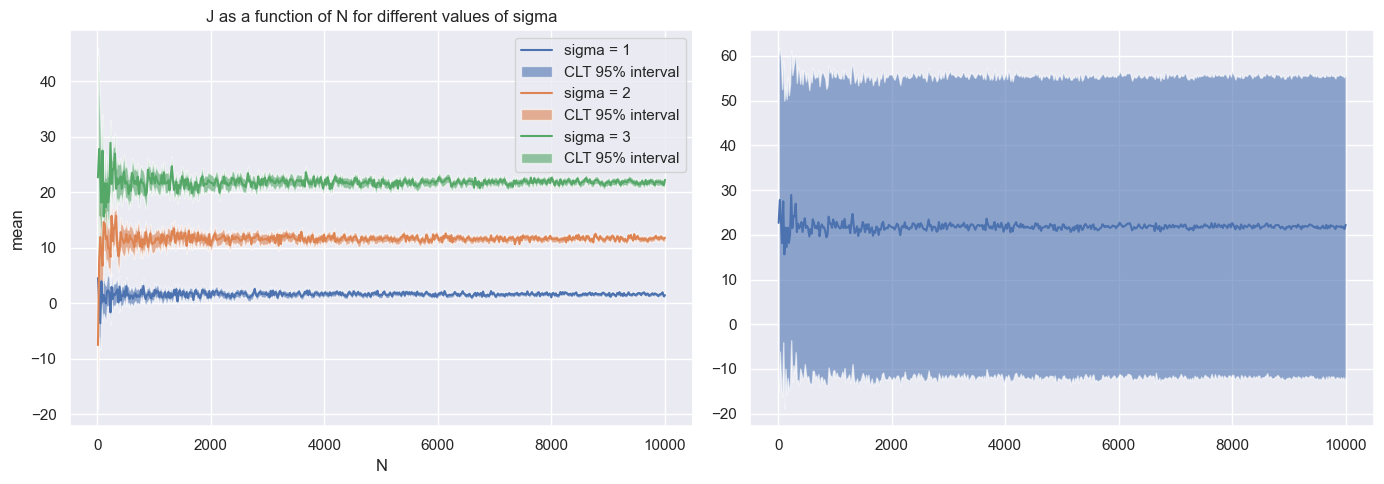

In [147]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50
sigma = [1,2,3]
N = np.linspace(10,10000,500,dtype=int)

mean = np.zeros(shape=(len(N), len(sigma)))
sdev = np.zeros(shape=(len(N), len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=m, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i, j] = np.mean(Z)
        sdev[i, j] = np.std(Z)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i in range(len(sigma)):
    axes[0].plot(N, mean[:, i], label=f'sigma = {sigma[i]}')
    axes[0].fill_between(N, mean[:,i] - 1.96* sdev[:,i] / np.sqrt(N), mean[:,i] + 1.96*sdev[:,i] / np.sqrt(N), alpha=0.6, label=f"CLT 95% interval")

axes[0].legend()
axes[0].set_xlabel('N')
axes[0].set_ylabel('mean')
axes[0].set_title('J as a function of N for different values of sigma')

axes[1].plot(N, mean[:, i], label=f'sigma = {sigma[i]}')
axes[1].fill_between(N, mean[:,i] - sdev[:,i] , mean[:,i] + sdev[:,i] , alpha=0.6, label=f"CLT 95% interval")
plt.tight_layout()
plt.show()

Estimator J:

- standard deviation of the estimator is a sort of -x^2 curve

Text(0.5, 1.0, 'standard deviation of J estimator as a function of sigma')

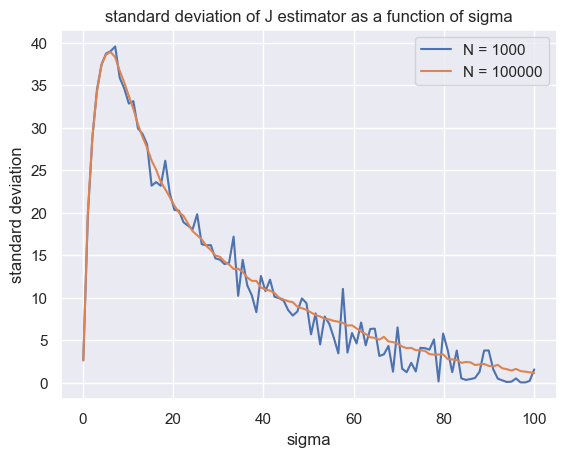

In [8]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50

N = [1000,100000]

sigma = np.linspace(0.1, 100, 100)
sdev = np.zeros(shape=(len(sigma),))

for j in range(len(N)):
    for i in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[i], r, T, m= m, N=N[j])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        sdev[i] = np.std(Z)
    plt.plot(sigma, sdev, label='N = ' + str(N[j]))

plt.legend()
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.title('standard deviation of J estimator as a function of sigma')


Just present CLT, yields same result as Berry Essen

Text(0.5, 1.0, 'Number of simulations (N) needed to have a 95% CLT confidence interval of length 1.0 of J with different values of sigma')

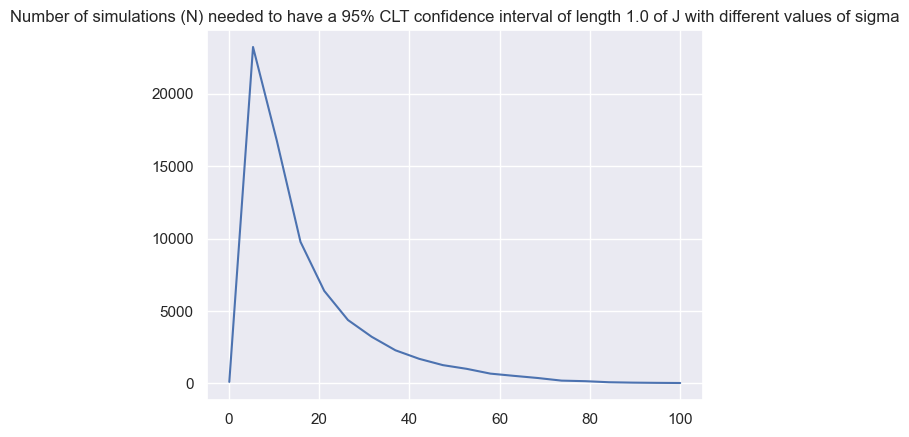

In [9]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
N,m = 100000,50
tol = 1/2

sigma_values = np.linspace(0.1, 100, 20)
St_dev = np.zeros(shape=(len(sigma_values),))

for i,sigma in enumerate(sigma_values):
    simulations = Simulate_Stock_Price(S0, sigma , r, T, m= 50, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    St_dev[i] = np.std(Z)

plt.plot(sigma_values, ((1.96*St_dev/tol )**2))
plt.title(f"Number of simulations (N) needed to have a 95% CLT confidence interval of length {2*tol} of J with different values of sigma")


In [145]:
sigma = 0.8
N,m = 4000,50
alpha = 0.05
tol = 0.5

#Generate N simulations of the GBM
simulations = Simulate_Stock_Price(S0, sigma , r, T, m=50, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
Jhat = np.mean(Z)
Jhat_sd = np.std(Z)
Jhat_skew = st.skew(Z)

#Intervals
margin = 1.96 * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = Jhat_sd / np.sqrt(alpha*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * Jhat_sd * Jhat_skew**3/(np.sqrt(N) *  Jhat_sd**3) + 1 - alpha/2)
margin = xalpha * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Annexe
sigma = 1
N,m = 4000,50
alpha = 0.05
tol = 0.5

#Generate N simulations of the GBM
simulations = Simulate_Stock_Price(S0, sigma , r, T, m=50, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
Jhat = np.mean(Z)
Jhat_sd = np.std(Z)
Jhat_skew = st.skew(Z)


print(f"standard deviation for sigma={sigma} is {Jhat_sd}")
print(f"A 95% CLT confidence interval yields that we need {int((1.96*Jhat_sd/tol )**2)} simulations to have a 95% confidence interval of length {2*tol} for sigma = {sigma}")


CLT 95% Confidence Interval: (-0.8171514727897669, 0.18759770024293992)
Chebyshev 95% Confidence Interval: (-1.4610459940478169, 0.8314922215009899)
Barry-Essen 95% Confidence Interval: (-0.817144239382547, 0.18759046683572006)
standard deviation for sigma=1 is 18.912179588149144
A 95% CLT confidence interval yields that we need 5496 simulations to have a 95% confidence interval of length 1.0 for sigma = 1


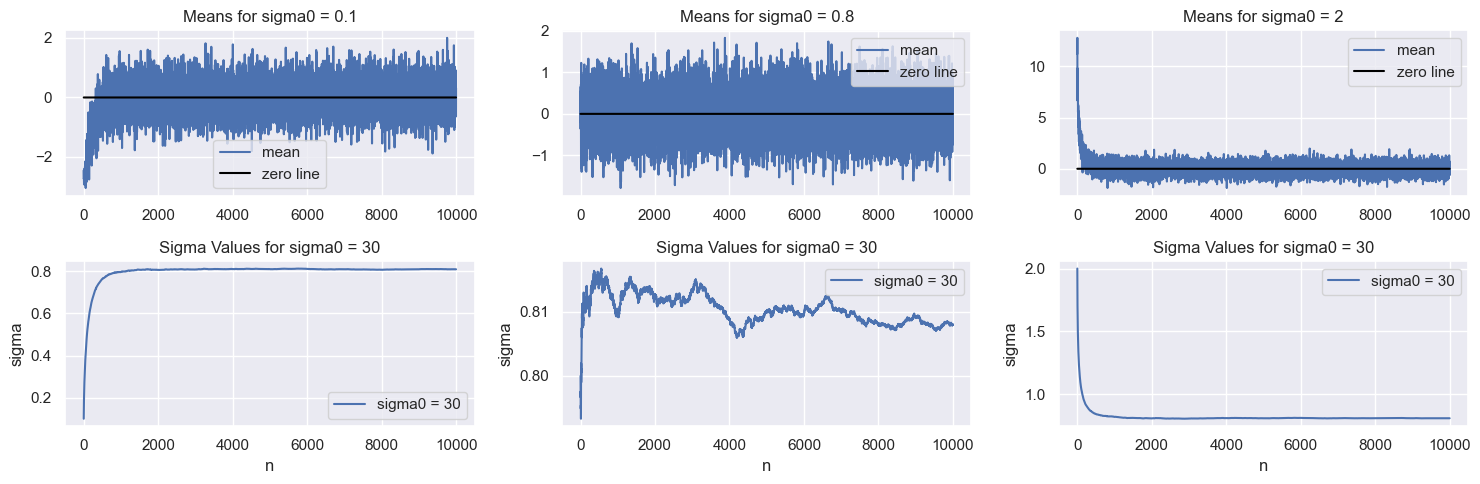

In [148]:
n = 10000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

rho = 0.5
sigma0_values = [0.1,0.8,2]


fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i, sigma0 in enumerate(sigma0_values):
    
    sigmas,means = RM_Asian_mean(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(means, label='mean')
    axs[0, i].plot(np.zeros(shape=(n,)),color='black',label='zero line')
    axs[0, i].set_title(f'Means for sigma0 = {sigma0}')
    axs[0, i].legend()

    # Plotting sigma values in the third column
    axs[1, i].plot(range(n), sigmas, label=f'sigma0 = {sigma_0}')
    axs[1, i].set_title(f'Sigma Values for sigma0 = {sigma_0}')
    axs[1, i].legend()
    axs[1, i].set_xlabel('n')
    axs[1, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()


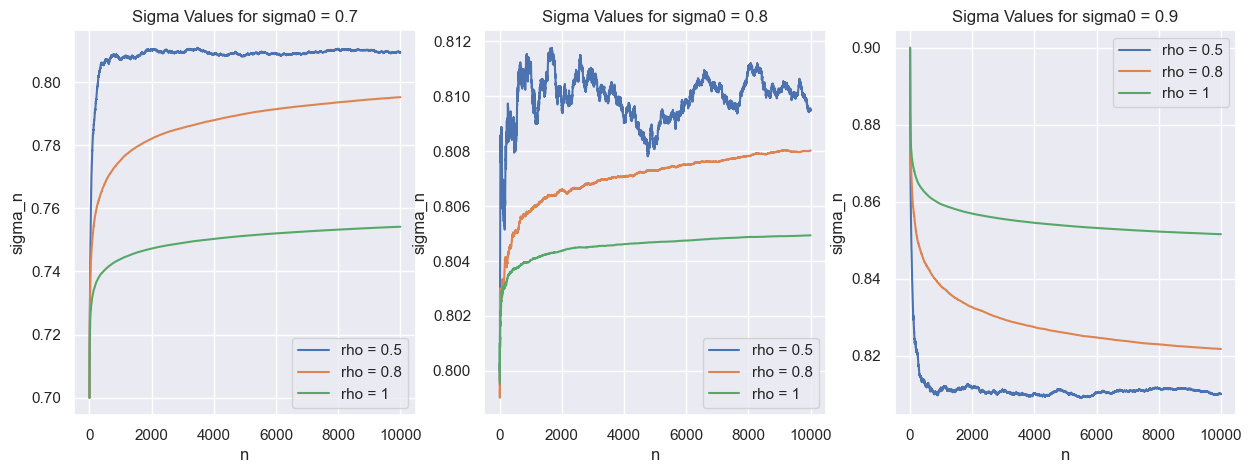

In [42]:
n = 10000
N,m = 4000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma_0_values = [0.7,0.8,0.9]
rho_values = [0.5,0.8,1]

fig, axes = plt.subplots(1,len(sigma0_values), figsize=(15, 5))

for i, sigma_0 in enumerate(sigma_0_values):
    for j,rho in enumerate(rho_values):
        sigmas= RM_Asian(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma_0)
        axes[i].plot(sigmas, label=f'rho = {rho}')
        axes[i].set_title(f'Sigma Values for sigma0 = {sigma_0}')
    axes[i].legend()
    axes[i].set_xlabel('n')
    axes[i].set_ylabel('sigma_n')

Stopping criterion: As we can see from the analysis above, the algorithm should converge when Jhat(sigma) is close to 0. In order to create a robust stopping criterion, we take a window of size 1000 and measure the value of Jhat(sigma_n). When both Jhat(sigma_n) and the mean value of the Jhat(sigma_n) inside this window is close to 0, we stop the algorithm.

Stopped at iteration n = 6570, where sigma_n = 0.8089838038497044


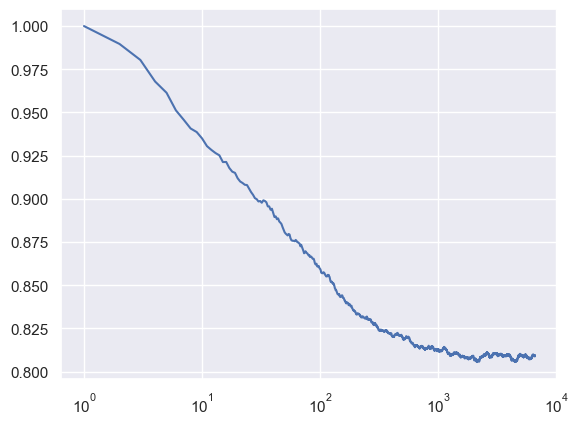

In [6]:
def RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    sigma_cur = sigma_0
    sigma_estim = deque([sigma_0])
    J_estim = deque([])
    window_size = 1000

    i = 1
    
    while True:
        alpha_n = alpha_0 / i ** rho

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        Jhat, est_std = np.mean(Z), np.std(Z)
        sigma_cur = sigma_cur - alpha_n * Jhat
        sigma_estim.append(sigma_cur)
        J_estim.append(Jhat)

        # Stopping Criterion
        if i == window_size:
            mean_value = np.mean(J_estim)
        if i > window_size:
            removed_value = J_estim.popleft()
            mean_value = mean_value + (Jhat - removed_value) / window_size
            if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                break
        i += 1

    print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

N,m,rho = 1000,50,0.5
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigmas = RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m)
plt.plot(range(1,len(sigmas)+1), sigmas)
plt.xscale('log')

Question 6: Importance Sampling

In [ ]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


- Compute in R -> R, realize the r_optimal depends on S0.
- Or, in the asian option, we need to find a r_tilde optimal for S_1,...,S_m. 
- Therefore we need to find a r_tilde optimal for each S_i.
- We take it as the average of the optimal r_tilde for each S_i / We go back to dimension 1 and assume S_0 is the sum of the S_i. For sigma in the range of 0.7 to 0.9 its around 70

In [149]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8
m = 50

Q=[]
sigma = 0.7
for i in range(0,50):
    Q = np.append(Q,S0 * np.exp( (r-sigma**2/2) * T/m * i * (i-1) / 2 ))

mu_path = np.mean(Q)
print(f"The mean of the path is {mu_path} sigma = {sigma}")

Q=[]
sigma = 0.8
for i in range(1,51):
    Q = np.append(Q,S0 * np.exp( (r-sigma**2/2) * T/m * i * (i-1) / 2 ))

mu_path = np.mean(Q)
print(f"The mean of the path is {mu_path} sigma = {sigma}")

Q=[]
sigma = 0.9
for i in range(1,51):
    Q = np.append(Q,S0 * np.exp( (r-sigma**2/2) * T/m * i * (i-1) / 2 ))

mu_path = np.mean(Q)
print(f"The mean of the path is {mu_path} sigma = {sigma}")

mu_N = np.log(mu_path) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")

The mean of the path is 76.39855983947673 sigma = 0.7
The mean of the path is 68.63071133315138 sigma = 0.8
The mean of the path is 62.57021142265662 sigma = 0.9
The mean of GBM is 63.199052501946106
 99% of the mass of the distribution is between 22.850028201996086 and 148.65471480067205


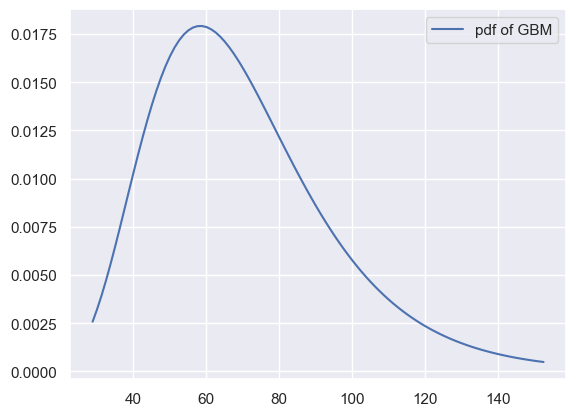

The mean of GBM is 70.70351169589178 and the standard deviation is 26.127124335591716
 99% of the mass of the distribution is between 28.852473456581993 and 152.4436103936783


In [107]:
K, S0, r, T, I_market = 80, 70, 0.05, 0.2, 22
sigma = 0.8

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

x = np.linspace(st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N),st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N),100)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z2 = np.zeros(shape=(len(x)))
z2 = np.exp(-r*T) * np.maximum( 0,(K - x) )

plt.plot(x,z, label = "pdf of GBM")

plt.legend()
plt.show()
print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)} and the standard deviation is { np.sqrt( (np.exp(sd_N ** 2) - 1) * np.exp(2 * mu_N + sd_N ** 2) )}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")

In [118]:
alpha = 0.05

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r = {r}")

r_tilde = -2.6

mu_N_tilde = np.log(S0) + (r_tilde-0.5*sigma**2) * T

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N_tilde), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r_tilde = {r_tilde}")  

 There is a 0.05 probability that the GBM is bigger than 119.45932844666146 with r = -5
 There is a 0.05 probability that the GBM is bigger than 70.31435439814386 with r_tilde = -2.6


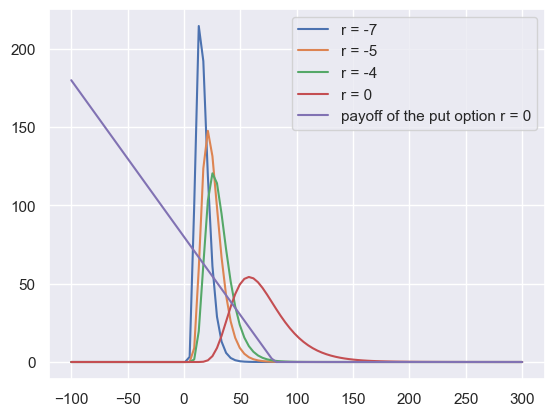

In [111]:
x = np.linspace(-100,300,100)
y = np.maximum( 0,(K - x) )

r_values = [-7,-5,-3-1,0]

for i in range(len(r_values)):

    mu_N = np.log(S0) + (r_values[i]-0.5*sigma**2) * T

    z = 3000 *st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
    z2 = np.maximum( 0,(K - x) )

    plt.plot(x,z, label = f"r = {r_values[i]}")


plt.plot(x,y, label = f"payoff of the put option r = 0")
plt.legend()
plt.show()

Actually I want to approximate f(x)*p(x)

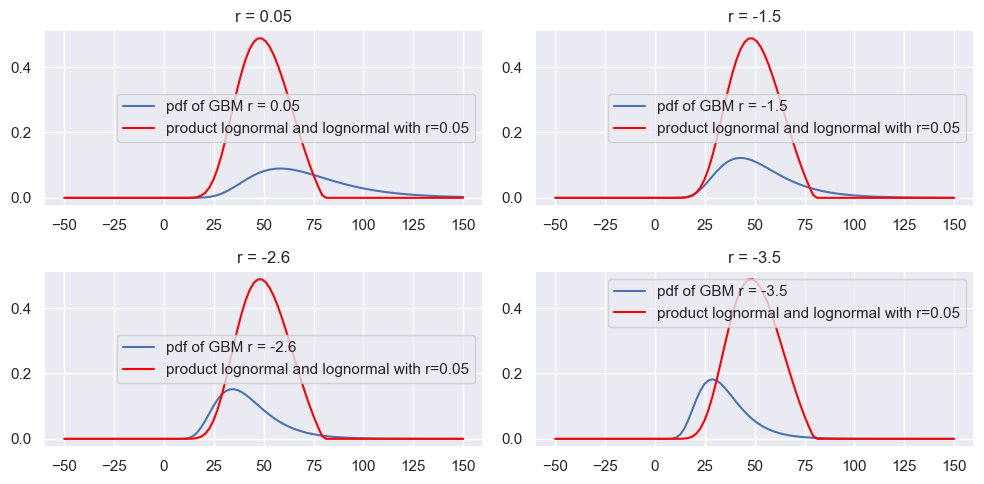

In [131]:
K, S0, r, T, I_market = 80, 70, 0.05, 0.2, 22
sigma = 0.8

x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

r_values = [0.05,-1.5,-2.6,-3.5]

fig, axes = plt.subplots(2,2,figsize=(10, 5))

for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,5 *z_tilde, label = f"pdf of GBM r = {r}")
    axes[i//2,i%2].plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")

plt.tight_layout()

Let us compute the mean value of f(x)*p(x)


In [133]:
# Retrieve the max of f * p, which is in between 0 and 100 and it is the mean of this new pdf called g
x = np.linspace(0,100,1000000)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

mu_g = x[np.argmax(g)]
print(f"The mean of g is {mu_g}")

The mean of g is 48.106848106848105


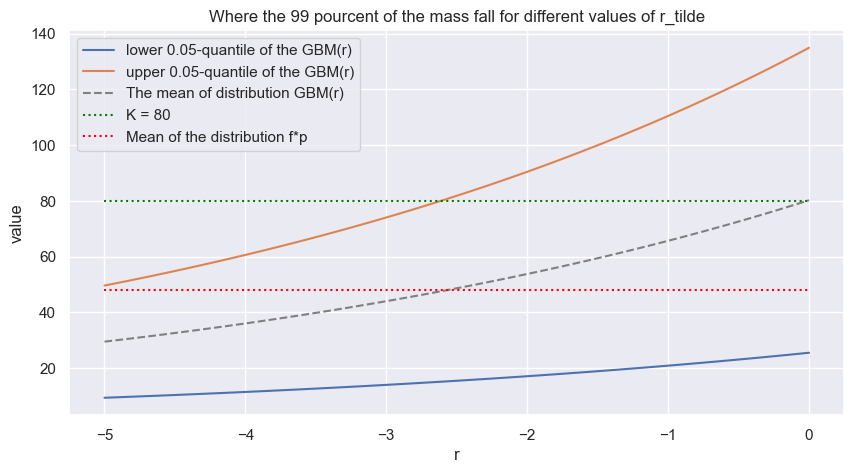

In [140]:
r = np.linspace(-5,0,100)
sd_N = np.sqrt( sigma ** 2 * T)
y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)

for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.figure(figsize=(10, 5))
plt.plot(r,y1, label = "lower 0.05-quantile of the GBM(r)")
plt.plot(r,y2, label = "upper 0.05-quantile of the GBM(r)")
plt.plot(r,y3, label = "The mean of distribution GBM(r)", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = "K = 80",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution f*p",color="red",linestyle='dotted')
plt.title("Where the 99 pourcent of the mass fall for different values of r_tilde")
plt.xlabel("r")
plt.ylabel("value")
plt.legend()
plt.show()

Question 6(b): Implementation of RM algorithm with Importance Sampling

In [8]:
# Calculate likelihood ratio
def w(S_T, S_0, sigma, r, r_tilde, T):
    return (S_T/S_0)**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))

def RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    if n:
        sigma_estim = np.empty((n,))
        sigma_cur = sigma_0
        
        for i in range(1, n):
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat with IS
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim[i] = sigma_cur
    else:
        sigma_cur = sigma_0
        sigma_estim = deque([sigma_0])
        J_estim = deque([])
        window_size = 1000
        i = 1
        while True:
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market
            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim.append(sigma_cur)
            J_estim.append(Jhat)

            # Stopping Criterion
            if i == window_size:
                mean_value = np.mean(J_estim)
            if i > window_size:
                removed_value = J_estim.popleft()
                mean_value = mean_value + (Jhat - removed_value) / window_size
                if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                    break
            i += 1

        print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

In [11]:
n, N, rho = None, 1000, 0.6
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = -3.6
m = 50

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
sigmas = RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m)

Stopped at iteration n = 4054, where sigma_n = 1.1092671894631216
Stopped at iteration n = 4549, where sigma_n = 1.1092410322817727


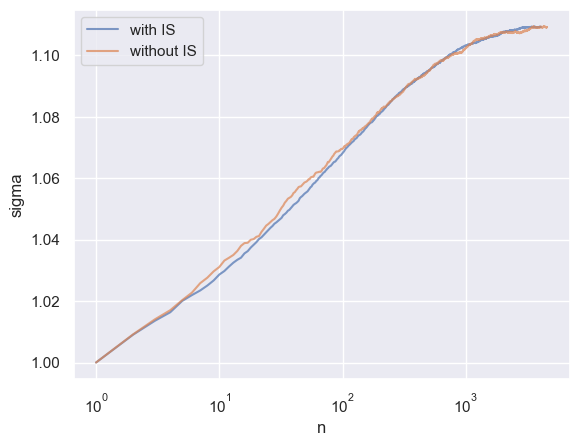

In [12]:
plt.plot(range(1, len(sigmas_IS)+1), sigmas_IS, label="with IS", alpha=0.7)
plt.plot(range(1, len(sigmas)+1), sigmas, label="without IS", alpha=0.7)

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

plt.xscale('log')

Question 7:

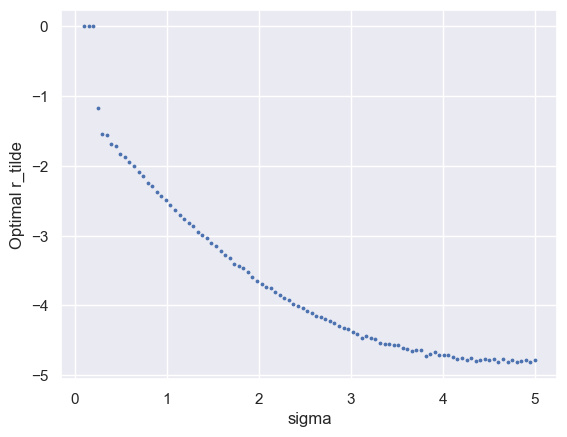

In [42]:
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

K, S0, T, r = 80, 100, 0.2, 0.05
m = 50
N = 100000
def find_optimal_r_tilde(sigmas, S0, K, r, T, m, N):
    def g(eta, sigma, simulations):
        likelihood_ratios = w(simulations[:, -1], S0, sigma, r, eta, T)
        
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs_squared = (np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0))**2
        variance = np.mean(np.multiply(payoffs_squared, likelihood_ratios))
        return variance
    
    if type(sigmas) == float:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
        return minimize_scalar(g, args=(sigmas,simulations)).x
    else:
        result = np.empty((len(sigmas),))
        for i, sigma in enumerate(sigmas):
            simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
            result[i] = minimize_scalar(g, args=(sigma,simulations)).x

        return result
sigmas = np.linspace(0.1, 5, num=100)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)
plt.scatter(sigmas, result, s=3)
plt.xlabel('sigma')
plt.ylabel('Optimal r_tilde')

# Spline interpolation
spline_interp = interp1d(sigmas, result, kind='cubic')

In [62]:
def RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    if n is not None:
        sigma_estim = np.empty((n,))
        sigma_cur = sigma_0
        
        for i in range(1, n):
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat with IS
            r_tilde = spline_interp(sigma_cur)
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim[i] = sigma_cur
    else:
        sigma_cur = sigma_0
        sigma_estim = deque([sigma_0])
        J_estim = deque([])
        window_size = 1000
        i=1
        while True:
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat
            r_tilde = spline_interp(sigma_cur)
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market
            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim.append(sigma_cur)
            J_estim.append(Jhat)

            # Stopping Criterion
            if i == window_size:
                mean_value = np.mean(J_estim)
            if i > window_size:
                removed_value = J_estim.popleft()
                mean_value = mean_value + (Jhat - removed_value) / window_size
                if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                    break
            i += 1
        print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

In [63]:
n, N, rho = 10**4, 10, 0.6
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = -2.6
m = 50

sigmas_IS_opt = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m)
sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m)

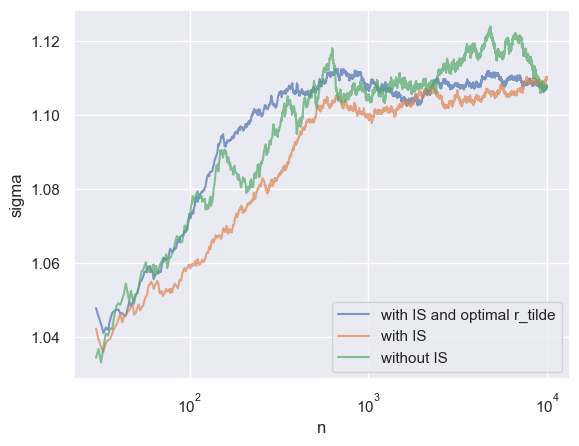

In [64]:
plt.plot(range(30,len(sigmas_IS_opt)), sigmas_IS_opt[30:], label="with IS and optimal r_tilde", alpha=0.7)
plt.plot(range(30,len(sigmas_IS)), sigmas_IS[30:], label="with IS", alpha=0.7)
plt.plot(range(30,len(sigmas)), sigmas[30:], label="without IS", alpha=0.7)

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

plt.xscale('log')

In [65]:
class VarianceAnalyzer:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []

    def update(self, new_value):
        self.values.append(new_value)
        if len(self.values) > self.window_size:
            self.values.pop(0)
            return self.calculate_var()
        return 0

    def calculate_var(self):
        if len(self.values) < 2:
            return None  # Variance is undefined with less than two values
        return np.var(self.values, ddof=1)  # ddof=1 for unbiased variance estimation

window_size = 5000
variance_analyzer = VarianceAnalyzer(window_size)

variance_1 = [variance_analyzer.update(value) for value in sigmas_IS_opt]
variance_2 = [variance_analyzer.update(value) for value in sigmas_IS]
variance_3 = [variance_analyzer.update(value) for value in sigmas]


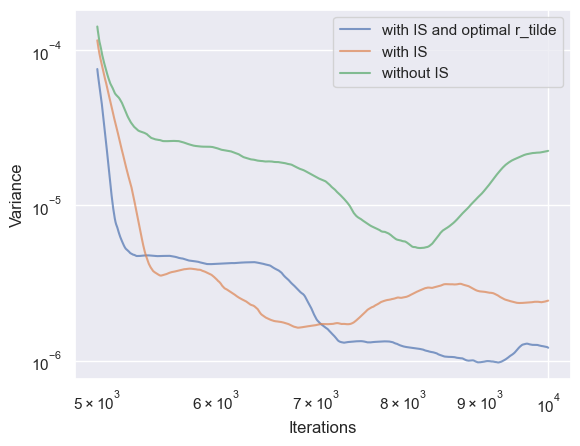

In [68]:
plt.plot(range(window_size, len(variance_1)), variance_1[window_size:], label='with IS and optimal r_tilde', alpha=0.7)
plt.plot(range(window_size, len(variance_2)), variance_2[window_size:], label='with IS', alpha=0.7)
plt.plot(range(window_size, len(variance_3)), variance_3[window_size:], label='without IS', alpha=0.7)

plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()